In [1]:
from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.nn import Transformer
import torch.nn.functional as F
from torch import Tensor
from torch import nn
import warnings
import random
import torch
import math
import json
import string
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
# warnings.filterwarnings("ignore")

In [2]:
if torch.cuda.is_available():
    device = 'cuda:0'
    print("[INFO] Current device:", torch.cuda.get_device_name(torch.cuda.current_device()), f", device num:{torch.cuda.current_device()}")
elif torch.has_mps:
    device = 'mps'
    print("[INFO] Current device: MAC OS Metal Performance Shaders.")
else:
    device = 'cpu'
    print("[INFO] Current device: CPU")
    print("*"*50,"\n[WARNING] You may need to change the device to GPU or MPS to get better performance.")
    print("*"*50)
device = torch.device(device)

[INFO] Current device: Tesla V100-PCIE-32GB , device num:0


# Preparing data

In [3]:
char2index = {'sos': 0, 'eos': 1, 'pad': 2, **{char: i + 3 for i, char in enumerate(string.ascii_lowercase)}}
index2char = {i: char for char, i in char2index.items()}

In [4]:
class SpellCorrectionDataset(Dataset):
    def __init__(self, root, split = 'train', padding = 21):
        super(SpellCorrectionDataset, self).__init__()
        self.data, self.targets = self.load_data(root, split)
        self.padding = padding

    def load_data(self, root, split):
        file_path = f"{root}/{split}.json"
        with open(file_path, 'r') as file:
            data = json.load(file)
        input_list, target_list = [], []
        for item in data:
            input_list.extend(item['input'])
            target_list.extend([item['target']] * len(item['input']))
            
        return input_list, target_list

    def tokenize(self, text):
        return [char2index.get(char, char2index['pad']) for char in text]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        input_text = self.data[index]
        target_text = self.targets[index]
        input_ids = [char2index['sos']] + self.tokenize(input_text) + [char2index['eos']] + [char2index['pad']] * (self.padding - len(input_text) - 2)
        target_ids = [char2index['sos']] + self.tokenize(target_text) + [char2index['eos']] + [char2index['pad']] * (self.padding - len(target_text) - 2)
        return torch.tensor(input_ids, dtype = torch.long), torch.tensor(target_ids, dtype = torch.long)

In [5]:
root_path = '../data/'
trainset = SpellCorrectionDataset(root_path, split = 'train')
trainloader = DataLoader(trainset, batch_size = 16, shuffle = True)
valset = SpellCorrectionDataset(root_path, split = 'test')
valloader = DataLoader(valset, batch_size = 16, shuffle = False)
testset = SpellCorrectionDataset(root_path, split = 'new_test')
testloader = DataLoader(testset, batch_size = 16, shuffle = False)

# Building the model

In [6]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000, batch_first: bool = False):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)
        self.batch_first = batch_first

    def forward(self, x: Tensor) -> Tensor:
        if self.batch_first:
            x = x.transpose(0, 1)
            x = x + self.pe[:x.size(0)]
            return self.dropout(x.transpose(0, 1))
        else:
            x = x + self.pe[:x.size(0)]
            return self.dropout(x)

In [7]:
class Encoder(nn.Module):
    def __init__(self, num_emb, hid_dim, n_layers, n_heads, ff_dim, dropout, max_length = 100):
        super(Encoder, self).__init__()
        
        self.tok_embedding = nn.Embedding(num_emb, hid_dim)
        self.pos_embedding = PositionalEncoding(hid_dim, dropout, max_length, batch_first = True)
        self.layer = TransformerEncoderLayer(hid_dim, n_heads, ff_dim, dropout, batch_first = True, norm_first = True)
        self.encoder = TransformerEncoder(self.layer,  n_layers)

    def forward(self, src, src_pad_mask):
        src = self.tok_embedding(src)
        src = self.pos_embedding(src)
        src = self.encoder(src, src_key_padding_mask = src_pad_mask)
        return src

class Decoder(nn.Module):
    def __init__(self, num_emb, hid_dim, n_layers, n_heads, ff_dim, dropout, max_length = 100):
        super(Decoder, self).__init__()
        
        self.tok_embedding = nn.Embedding(num_emb, hid_dim)
        self.pos_embedding = PositionalEncoding(hid_dim, dropout, max_length, batch_first = True)
        self.layer = TransformerDecoderLayer(hid_dim, n_heads, ff_dim, dropout, activation = 'relu', batch_first = True, norm_first = True)
        self.decoder = TransformerDecoder(self.layer, n_layers)
        self.linear = nn.Linear(hid_dim, num_emb)

    def forward(self, tgt, memory, tgt_mask, tgt_pad_mask, src_pad_mask):
        tgt = self.tok_embedding(tgt)
        tgt = self.pos_embedding(tgt)
        tgt = self.decoder(tgt, memory = memory, tgt_mask = tgt_mask, tgt_key_padding_mask = tgt_pad_mask, memory_key_padding_mask = src_pad_mask)
        tgt = self.linear(tgt)
        return tgt

class TransformerAutoEncoder(nn.Module):
    def __init__(self, num_emb, hid_dim, n_layers, n_heads, ff_dim, dropout, max_length = 100, encoder = None):
        super(TransformerAutoEncoder, self).__init__()
        if encoder is None:
            self.encoder = Encoder(num_emb, hid_dim, n_layers, n_heads, ff_dim, dropout, max_length)
        else:
            self.encoder = encoder
        self.decoder = Decoder(num_emb, hid_dim, n_layers, n_heads, ff_dim, dropout, max_length)

    def forward(self, src, tgt, src_pad_mask, tgt_mask, tgt_pad_mask):
        enc_src = self.encoder(src, src_pad_mask)
        out = self.decoder(tgt, enc_src, tgt_mask, tgt_pad_mask, src_pad_mask)
        
        return out

In [8]:
def gen_padding_mask(src, pad_idx):
    pad_mask = (src == pad_idx)
    return pad_mask

def gen_mask(seq):
    mask_shape = seq, seq
    att_mask = torch.triu(torch.ones(mask_shape), diagonal = 1).bool()
    return att_mask

def get_index(pred, dim = 2):
    return pred.clone().argmax(dim = dim)

# Train our spelling correction transformer

In [ ]:
def index_to_char(lis, index2char, remove_token = True):
    if remove_token:
        lis = "".join([index2char[char] for char in lis]).split('eos')[0].replace('sos', '')
        return lis
    else:
        return [index2char[char] for char in lis]

In [9]:
def compute_bleu(output, reference):
    cc = SmoothingFunction()
    if len(reference) == 3:
        weights = (0.33, 0.33, 0.33)
    else:
        weights = (0.25, 0.25, 0.25, 0.25)
    return sentence_bleu([reference], output, weights = weights, smoothing_function = cc.method1)

In [10]:
def metrics(pred:list, target:list) -> float:
    if len(pred) != len(target):
        raise ValueError('length of pred and target must be the same')
    correct = 0
    for i in range(len(pred)):
        if pred[i] == target[i]:
            correct += 1
    return correct / len(pred) * 100

In [11]:
def validation(dataloader, model, device, logout = False):
    pred_str_list = []
    tgt_str_list = []
    input_str_list = []
    losses = []
    bleu_score = []
    model.eval()
    for src, tgt in dataloader:
            src, tgt = src.to(device), tgt.to(device)
            
            tgt_input = torch.ones_like(tgt) * 2
            tgt_input[:, 0] = 0
            for i in range(tgt.shape[1] - 1):
                src_pad_mask = gen_padding_mask(src, pad_idx = 2).to(device)
                tgt_pad_mask = gen_padding_mask(tgt_input, pad_idx = 2).to(device)
                tgt_mask = gen_mask(tgt_input.size(1)).to(device)
                
                pred = model(src, tgt_input, src_pad_mask, tgt_mask, tgt_pad_mask)
                
                tgt_input[:, i + 1] = get_index(pred)[:, i]
                
            for i in range (tgt.shape[0]):
                pred_str_list.append(index_to_char(tgt_input[i].tolist(), index2char))
                tgt_str_list.append(index_to_char(tgt[i].tolist(), index2char))
                input_str_list.append(index_to_char(src[i].tolist(), index2char))
                if logout:
                    print('='*20)
                    print(f'input: {input_str_list[-1]}')
                    print(f'pred: {pred_str_list[-1]}')
                    print(f'target: {tgt_str_list[-1]}')
            loss = ce_loss(pred[:, :-1, :].permute(0, 2, 1), tgt[:, 1:])
            losses.append(loss.item())
            
    for b in range(len(input_str_list)):
        bleu_score.append(compute_bleu(pred_str_list[b], tgt_str_list[b]))
            
    model.train()
    
    acc = metrics(pred_str_list, tgt_str_list)
    total_loss = sum(losses) / len(losses)
    bleu_score = np.mean(bleu_score)
    if logout == False:
        if dataloader == valloader:
            print(f"    test_acc:{acc:6.2f}%", f"|     test_loss:{total_loss:6.3f}", f"| bleu_score: {bleu_score:.3f}", end = ' | ')
            print(f"[pred: {pred_str_list[0]}, target: {tgt_str_list[0]}]")
        if dataloader == testloader:
            print(f"new_test_acc:{acc:6.2f}%", f"| new_test_loss:{total_loss:6.3f}", f"| bleu_score: {bleu_score:.3f}", end = ' | ')
            print(f"[pred: {pred_str_list[0]}, target: {tgt_str_list[0]}]")
    return acc, total_loss, bleu_score

In [12]:
embedding_num = 29
embedding_dim = 512
num_layers = 8
num_heads = 8
ff_dim = 1024
dropout = 0.1

model = TransformerAutoEncoder(embedding_num, embedding_dim, num_layers, num_heads, ff_dim, dropout).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = [50, 75, 100, 125], gamma = 0.5)
ce_loss = nn.CrossEntropyLoss(ignore_index = 2)

In [13]:
train_losses, val_losses, test_losses = [], [], []
val_bleus, test_bleus = [], []
val_accs, test_accs = [], []
best_val_acc = 0.0
best_test_acc = 0.0
best_avg_acc = 0.0

In [15]:
for eps in range(150):
    
    losses = []
    model.train()
    i_bar = tqdm(trainloader, unit = 'iter', desc = f'epoch{eps + 1}')
    for src, tgt in i_bar:
        src, tgt = src.to(device), tgt.to(device)
        
        src_pad_mask = gen_padding_mask(src, pad_idx = 2).to(device)
        tgt_pad_mask = gen_padding_mask(tgt, pad_idx = 2).to(device)
        tgt_mask = gen_mask(tgt.size(1)).to(device)
        
        optimizer.zero_grad()
        pred = model(src, tgt, src_pad_mask, tgt_mask, tgt_pad_mask)
        loss = ce_loss(pred[:, :-1, :].permute(0, 2, 1), tgt[:, 1:])
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        i_bar.set_postfix_str(f"loss: {sum(losses) / len(losses):.3f}")
    
    total_loss = sum(losses) / len(losses)
    train_losses.append(total_loss)
    scheduler.step()
    
    model.eval()
    with torch.no_grad():
        val_acc, val_loss, val_bleu = validation(valloader, model, device, logout = False)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_bleus.append(val_bleu)
    
    model.eval()
    with torch.no_grad():
        test_acc, test_loss, test_bleu = validation(testloader, model, device, logout = False)
    test_accs.append(test_acc)
    test_losses.append(test_loss)
    test_bleus.append(test_bleu)
    
    store = {
        'epoch': eps + 1,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'test_losses': test_losses,
        'val_bleus': val_bleus,
        'test_bleus': test_bleus,
        'val_accs': val_accs,
        'test_accs': test_accs
    }
    torch.save(store, 'all_store.pth')
    torch.save(model.state_dict(), 'latest-model.pth')
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best-model-val-acc.pth')

    if test_acc > best_test_acc:
        best_test_acc = test_acc
        torch.save(model.state_dict(), 'best-model-test-acc.pth')

    avg_acc = (val_acc + test_acc) / 2
    if avg_acc > best_avg_acc:
        best_avg_acc = avg_acc
        torch.save(model.state_dict(), 'best-model-avg-acc.pth')

epoch1: 100%|██████████| 808/808 [03:18<00:00,  4.06iter/s, loss: 2.289]


    test_acc:  2.00% |     test_loss: 2.009 | bleu_score: 0.262 | [pred: contend target: contented]
new_test_acc:  4.00% | new_test_loss: 1.906 | bleu_score: 0.249 | [pred: apecerice, target: appreciate]


epoch2: 100%|██████████| 808/808 [03:19<00:00,  4.04iter/s, loss: 1.330]


    test_acc:  8.00% |     test_loss: 2.093 | bleu_score: 0.413 | [pred: contented target: contented]
new_test_acc:  4.00% | new_test_loss: 1.423 | bleu_score: 0.385 | [pred: apprciate, target: appreciate]


epoch3: 100%|██████████| 808/808 [03:20<00:00,  4.02iter/s, loss: 1.132]


    test_acc:  6.00% |     test_loss: 2.270 | bleu_score: 0.440 | [pred: contented target: contented]
new_test_acc: 10.00% | new_test_loss: 1.462 | bleu_score: 0.395 | [pred: appricate, target: appreciate]


epoch4: 100%|██████████| 808/808 [03:22<00:00,  3.99iter/s, loss: 1.032]


    test_acc: 12.00% |     test_loss: 2.412 | bleu_score: 0.485 | [pred: contented target: contented]
new_test_acc: 10.00% | new_test_loss: 1.477 | bleu_score: 0.459 | [pred: apreciate, target: appreciate]


epoch5: 100%|██████████| 808/808 [03:21<00:00,  4.01iter/s, loss: 0.977]


    test_acc:  8.00% |     test_loss: 2.288 | bleu_score: 0.462 | [pred: contented target: contented]
new_test_acc: 10.00% | new_test_loss: 1.307 | bleu_score: 0.445 | [pred: appricate, target: appreciate]


epoch6: 100%|██████████| 808/808 [03:19<00:00,  4.04iter/s, loss: 0.929]


    test_acc: 14.00% |     test_loss: 2.094 | bleu_score: 0.506 | [pred: contented target: contented]
new_test_acc: 10.00% | new_test_loss: 1.307 | bleu_score: 0.475 | [pred: appreciate, target: appreciate]


epoch7: 100%|██████████| 808/808 [03:19<00:00,  4.05iter/s, loss: 0.894]


    test_acc: 20.00% |     test_loss: 2.163 | bleu_score: 0.551 | [pred: content target: contented]
new_test_acc: 14.00% | new_test_loss: 1.383 | bleu_score: 0.481 | [pred: appriciate, target: appreciate]


epoch8: 100%|██████████| 808/808 [03:19<00:00,  4.06iter/s, loss: 0.868]


    test_acc: 16.00% |     test_loss: 2.432 | bleu_score: 0.546 | [pred: contented target: contented]
new_test_acc: 12.00% | new_test_loss: 1.570 | bleu_score: 0.480 | [pred: apriciate, target: appreciate]


epoch9: 100%|██████████| 808/808 [03:21<00:00,  4.00iter/s, loss: 0.839]


    test_acc: 16.00% |     test_loss: 2.189 | bleu_score: 0.508 | [pred: contented target: contented]
new_test_acc:  8.00% | new_test_loss: 1.309 | bleu_score: 0.440 | [pred: appriciate, target: appreciate]


epoch10: 100%|██████████| 808/808 [03:22<00:00,  4.00iter/s, loss: 0.814]


    test_acc: 16.00% |     test_loss: 2.423 | bleu_score: 0.541 | [pred: contented target: contented]
new_test_acc: 14.00% | new_test_loss: 1.411 | bleu_score: 0.492 | [pred: apreciate, target: appreciate]


epoch11: 100%|██████████| 808/808 [03:21<00:00,  4.01iter/s, loss: 0.790]


    test_acc: 16.00% |     test_loss: 2.527 | bleu_score: 0.508 | [pred: contenpted target: contented]
new_test_acc: 14.00% | new_test_loss: 1.218 | bleu_score: 0.495 | [pred: appriciate, target: appreciate]


epoch12: 100%|██████████| 808/808 [03:20<00:00,  4.02iter/s, loss: 0.773]


    test_acc: 22.00% |     test_loss: 1.962 | bleu_score: 0.568 | [pred: contenpted target: contented]
new_test_acc: 18.00% | new_test_loss: 1.143 | bleu_score: 0.532 | [pred: appreciate, target: appreciate]


epoch13: 100%|██████████| 808/808 [03:21<00:00,  4.02iter/s, loss: 0.753]


    test_acc: 26.00% |     test_loss: 2.365 | bleu_score: 0.596 | [pred: contenpted target: contented]
new_test_acc: 16.00% | new_test_loss: 1.321 | bleu_score: 0.497 | [pred: appreciate, target: appreciate]


epoch14: 100%|██████████| 808/808 [03:19<00:00,  4.05iter/s, loss: 0.737]


    test_acc: 24.00% |     test_loss: 1.889 | bleu_score: 0.577 | [pred: contenpted target: contented]
new_test_acc: 14.00% | new_test_loss: 1.171 | bleu_score: 0.522 | [pred: appriciate, target: appreciate]


epoch15: 100%|██████████| 808/808 [03:22<00:00,  3.99iter/s, loss: 0.718]


    test_acc: 34.00% |     test_loss: 2.172 | bleu_score: 0.603 | [pred: contented target: contented]
new_test_acc: 18.00% | new_test_loss: 1.283 | bleu_score: 0.503 | [pred: appricate, target: appreciate]


epoch16: 100%|██████████| 808/808 [03:24<00:00,  3.95iter/s, loss: 0.703]


    test_acc: 26.00% |     test_loss: 2.233 | bleu_score: 0.596 | [pred: contenpted target: contented]
new_test_acc: 16.00% | new_test_loss: 1.364 | bleu_score: 0.521 | [pred: appricate, target: appreciate]


epoch17: 100%|██████████| 808/808 [03:26<00:00,  3.92iter/s, loss: 0.691]


    test_acc: 28.00% |     test_loss: 1.854 | bleu_score: 0.596 | [pred: contenpted target: contented]
new_test_acc: 16.00% | new_test_loss: 1.426 | bleu_score: 0.543 | [pred: appreciate, target: appreciate]


epoch18: 100%|██████████| 808/808 [03:25<00:00,  3.93iter/s, loss: 0.677]


    test_acc: 38.00% |     test_loss: 1.851 | bleu_score: 0.646 | [pred: contented target: contented]
new_test_acc: 18.00% | new_test_loss: 1.354 | bleu_score: 0.512 | [pred: appreciate, target: appreciate]


epoch19: 100%|██████████| 808/808 [03:28<00:00,  3.88iter/s, loss: 0.661]


    test_acc: 32.00% |     test_loss: 1.269 | bleu_score: 0.655 | [pred: contenpted target: contented]
new_test_acc: 20.00% | new_test_loss: 1.183 | bleu_score: 0.579 | [pred: appriciate, target: appreciate]


epoch20: 100%|██████████| 808/808 [03:25<00:00,  3.92iter/s, loss: 0.642]


    test_acc: 30.00% |     test_loss: 1.834 | bleu_score: 0.611 | [pred: contented target: contented]
new_test_acc: 22.00% | new_test_loss: 1.074 | bleu_score: 0.576 | [pred: appreciate, target: appreciate]


epoch21: 100%|██████████| 808/808 [03:25<00:00,  3.94iter/s, loss: 0.632]


    test_acc: 36.00% |     test_loss: 1.667 | bleu_score: 0.657 | [pred: contenpted target: contented]
new_test_acc: 18.00% | new_test_loss: 1.273 | bleu_score: 0.532 | [pred: appreciate, target: appreciate]


epoch22: 100%|██████████| 808/808 [03:25<00:00,  3.93iter/s, loss: 0.617]


    test_acc: 42.00% |     test_loss: 1.614 | bleu_score: 0.684 | [pred: contenpted target: contented]
new_test_acc: 22.00% | new_test_loss: 0.996 | bleu_score: 0.581 | [pred: appreciate, target: appreciate]


epoch23: 100%|██████████| 808/808 [03:24<00:00,  3.95iter/s, loss: 0.603]


    test_acc: 40.00% |     test_loss: 1.691 | bleu_score: 0.659 | [pred: contenpted target: contented]
new_test_acc: 18.00% | new_test_loss: 1.323 | bleu_score: 0.532 | [pred: appreciate, target: appreciate]


epoch24: 100%|██████████| 808/808 [03:23<00:00,  3.96iter/s, loss: 0.592]


    test_acc: 44.00% |     test_loss: 1.771 | bleu_score: 0.689 | [pred: contenpted target: contented]
new_test_acc: 20.00% | new_test_loss: 1.422 | bleu_score: 0.555 | [pred: appreciate, target: appreciate]


epoch25: 100%|██████████| 808/808 [03:26<00:00,  3.92iter/s, loss: 0.583]


    test_acc: 44.00% |     test_loss: 1.848 | bleu_score: 0.685 | [pred: contenpted target: contented]
new_test_acc: 22.00% | new_test_loss: 1.384 | bleu_score: 0.587 | [pred: appreciate, target: appreciate]


epoch26: 100%|██████████| 808/808 [03:24<00:00,  3.95iter/s, loss: 0.570]


    test_acc: 42.00% |     test_loss: 1.486 | bleu_score: 0.688 | [pred: contenpted target: contented]
new_test_acc: 20.00% | new_test_loss: 1.269 | bleu_score: 0.538 | [pred: appriciate, target: appreciate]


epoch27: 100%|██████████| 808/808 [03:24<00:00,  3.94iter/s, loss: 0.554]


    test_acc: 54.00% |     test_loss: 1.240 | bleu_score: 0.736 | [pred: contenpted target: contented]
new_test_acc: 20.00% | new_test_loss: 1.584 | bleu_score: 0.527 | [pred: appriciate, target: appreciate]


epoch28: 100%|██████████| 808/808 [03:26<00:00,  3.91iter/s, loss: 0.545]


    test_acc: 54.00% |     test_loss: 1.729 | bleu_score: 0.741 | [pred: contenpted target: contented]
new_test_acc: 24.00% | new_test_loss: 1.581 | bleu_score: 0.572 | [pred: appreciate, target: appreciate]


epoch29: 100%|██████████| 808/808 [03:25<00:00,  3.93iter/s, loss: 0.533]


    test_acc: 50.00% |     test_loss: 2.057 | bleu_score: 0.730 | [pred: contenpted target: contented]
new_test_acc: 22.00% | new_test_loss: 1.531 | bleu_score: 0.547 | [pred: appreciate, target: appreciate]


epoch30: 100%|██████████| 808/808 [03:26<00:00,  3.90iter/s, loss: 0.519]


    test_acc: 56.00% |     test_loss: 1.744 | bleu_score: 0.762 | [pred: contented target: contented]
new_test_acc: 26.00% | new_test_loss: 1.388 | bleu_score: 0.572 | [pred: appreciate, target: appreciate]


epoch31: 100%|██████████| 808/808 [03:25<00:00,  3.92iter/s, loss: 0.509]


    test_acc: 54.00% |     test_loss: 1.361 | bleu_score: 0.739 | [pred: contenpted target: contented]
new_test_acc: 24.00% | new_test_loss: 1.241 | bleu_score: 0.560 | [pred: appreciate, target: appreciate]


epoch32: 100%|██████████| 808/808 [03:25<00:00,  3.93iter/s, loss: 0.497]


    test_acc: 52.00% |     test_loss: 1.161 | bleu_score: 0.724 | [pred: contenpted target: contented]
new_test_acc: 26.00% | new_test_loss: 1.386 | bleu_score: 0.598 | [pred: appreciate, target: appreciate]


epoch33: 100%|██████████| 808/808 [03:25<00:00,  3.94iter/s, loss: 0.487]


    test_acc: 60.00% |     test_loss: 1.163 | bleu_score: 0.772 | [pred: contenpted target: contented]
new_test_acc: 26.00% | new_test_loss: 1.372 | bleu_score: 0.587 | [pred: appreciate, target: appreciate]


epoch34: 100%|██████████| 808/808 [03:24<00:00,  3.95iter/s, loss: 0.476]


    test_acc: 62.00% |     test_loss: 1.630 | bleu_score: 0.785 | [pred: contented target: contented]
new_test_acc: 24.00% | new_test_loss: 1.340 | bleu_score: 0.576 | [pred: appreciate, target: appreciate]


epoch35: 100%|██████████| 808/808 [03:26<00:00,  3.91iter/s, loss: 0.466]


    test_acc: 60.00% |     test_loss: 1.145 | bleu_score: 0.755 | [pred: contented target: contented]
new_test_acc: 22.00% | new_test_loss: 1.485 | bleu_score: 0.544 | [pred: appreciate, target: appreciate]


epoch36: 100%|██████████| 808/808 [03:25<00:00,  3.94iter/s, loss: 0.456]


    test_acc: 72.00% |     test_loss: 0.857 | bleu_score: 0.824 | [pred: contented target: contented]
new_test_acc: 24.00% | new_test_loss: 1.162 | bleu_score: 0.536 | [pred: appreciate, target: appreciate]


epoch37: 100%|██████████| 808/808 [03:26<00:00,  3.92iter/s, loss: 0.446]


    test_acc: 58.00% |     test_loss: 1.357 | bleu_score: 0.742 | [pred: contented target: contented]
new_test_acc: 26.00% | new_test_loss: 1.558 | bleu_score: 0.568 | [pred: appriciate, target: appreciate]


epoch38: 100%|██████████| 808/808 [03:23<00:00,  3.96iter/s, loss: 0.433]


    test_acc: 64.00% |     test_loss: 1.096 | bleu_score: 0.796 | [pred: contenpted target: contented]
new_test_acc: 22.00% | new_test_loss: 1.451 | bleu_score: 0.557 | [pred: appreciate, target: appreciate]


epoch39: 100%|██████████| 808/808 [03:25<00:00,  3.93iter/s, loss: 0.424]


    test_acc: 74.00% |     test_loss: 0.814 | bleu_score: 0.848 | [pred: contented target: contented]
new_test_acc: 28.00% | new_test_loss: 1.325 | bleu_score: 0.589 | [pred: appreciate, target: appreciate]


epoch40: 100%|██████████| 808/808 [03:26<00:00,  3.92iter/s, loss: 0.415]


    test_acc: 74.00% |     test_loss: 0.841 | bleu_score: 0.843 | [pred: contented target: contented]
new_test_acc: 24.00% | new_test_loss: 1.168 | bleu_score: 0.581 | [pred: appreciate, target: appreciate]


epoch41: 100%|██████████| 808/808 [03:26<00:00,  3.91iter/s, loss: 0.403]


    test_acc: 68.00% |     test_loss: 0.938 | bleu_score: 0.808 | [pred: contented target: contented]
new_test_acc: 32.00% | new_test_loss: 1.358 | bleu_score: 0.620 | [pred: appreciate, target: appreciate]


epoch42: 100%|██████████| 808/808 [03:24<00:00,  3.95iter/s, loss: 0.394]


    test_acc: 78.00% |     test_loss: 0.459 | bleu_score: 0.854 | [pred: contented target: contented]
new_test_acc: 34.00% | new_test_loss: 1.391 | bleu_score: 0.643 | [pred: appreciate, target: appreciate]


epoch43: 100%|██████████| 808/808 [03:24<00:00,  3.95iter/s, loss: 0.387]


    test_acc: 72.00% |     test_loss: 0.858 | bleu_score: 0.809 | [pred: contented target: contented]
new_test_acc: 30.00% | new_test_loss: 1.348 | bleu_score: 0.598 | [pred: appreciate, target: appreciate]


epoch44: 100%|██████████| 808/808 [03:25<00:00,  3.93iter/s, loss: 0.378]


    test_acc: 66.00% |     test_loss: 0.697 | bleu_score: 0.762 | [pred: contented target: contented]
new_test_acc: 28.00% | new_test_loss: 1.510 | bleu_score: 0.584 | [pred: appreciate, target: appreciate]


epoch45: 100%|██████████| 808/808 [03:27<00:00,  3.90iter/s, loss: 0.366]


    test_acc: 76.00% |     test_loss: 0.725 | bleu_score: 0.838 | [pred: contented target: contented]
new_test_acc: 30.00% | new_test_loss: 1.319 | bleu_score: 0.603 | [pred: appreciate, target: appreciate]


epoch46: 100%|██████████| 808/808 [03:24<00:00,  3.95iter/s, loss: 0.358]


    test_acc: 72.00% |     test_loss: 1.306 | bleu_score: 0.804 | [pred: contented target: contented]
new_test_acc: 26.00% | new_test_loss: 1.680 | bleu_score: 0.580 | [pred: appriciate, target: appreciate]


epoch47: 100%|██████████| 808/808 [03:25<00:00,  3.93iter/s, loss: 0.348]


    test_acc: 80.00% |     test_loss: 0.375 | bleu_score: 0.863 | [pred: contented target: contented]
new_test_acc: 26.00% | new_test_loss: 1.504 | bleu_score: 0.584 | [pred: appreciate, target: appreciate]


epoch48: 100%|██████████| 808/808 [03:24<00:00,  3.95iter/s, loss: 0.339]


    test_acc: 86.00% |     test_loss: 0.430 | bleu_score: 0.919 | [pred: contented target: contented]
new_test_acc: 28.00% | new_test_loss: 1.521 | bleu_score: 0.594 | [pred: approciate, target: appreciate]


epoch49: 100%|██████████| 808/808 [03:25<00:00,  3.93iter/s, loss: 0.331]


    test_acc: 88.00% |     test_loss: 0.406 | bleu_score: 0.924 | [pred: contented target: contented]
new_test_acc: 34.00% | new_test_loss: 1.462 | bleu_score: 0.625 | [pred: appreciate, target: appreciate]


epoch50: 100%|██████████| 808/808 [03:25<00:00,  3.93iter/s, loss: 0.324]


    test_acc: 82.00% |     test_loss: 0.407 | bleu_score: 0.869 | [pred: contented target: contented]
new_test_acc: 30.00% | new_test_loss: 1.493 | bleu_score: 0.593 | [pred: appreciate, target: appreciate]


epoch51: 100%|██████████| 808/808 [03:26<00:00,  3.91iter/s, loss: 0.288]


    test_acc: 88.00% |     test_loss: 0.324 | bleu_score: 0.902 | [pred: continupted target: contented]
new_test_acc: 36.00% | new_test_loss: 1.340 | bleu_score: 0.635 | [pred: appreciate, target: appreciate]


epoch52: 100%|██████████| 808/808 [03:24<00:00,  3.94iter/s, loss: 0.278]


    test_acc: 90.00% |     test_loss: 0.416 | bleu_score: 0.924 | [pred: contented target: contented]
new_test_acc: 36.00% | new_test_loss: 1.238 | bleu_score: 0.637 | [pred: appreciate, target: appreciate]


epoch53: 100%|██████████| 808/808 [03:23<00:00,  3.96iter/s, loss: 0.271]


    test_acc: 94.00% |     test_loss: 0.377 | bleu_score: 0.956 | [pred: contented target: contented]
new_test_acc: 36.00% | new_test_loss: 1.327 | bleu_score: 0.631 | [pred: appreciate, target: appreciate]


epoch54: 100%|██████████| 808/808 [03:24<00:00,  3.96iter/s, loss: 0.264]


    test_acc: 90.00% |     test_loss: 0.409 | bleu_score: 0.923 | [pred: contented target: contented]
new_test_acc: 32.00% | new_test_loss: 1.652 | bleu_score: 0.605 | [pred: appreciate, target: appreciate]


epoch55: 100%|██████████| 808/808 [03:26<00:00,  3.91iter/s, loss: 0.262]


    test_acc: 94.00% |     test_loss: 0.341 | bleu_score: 0.956 | [pred: contented target: contented]
new_test_acc: 38.00% | new_test_loss: 1.321 | bleu_score: 0.638 | [pred: appreciate, target: appreciate]


epoch56: 100%|██████████| 808/808 [03:25<00:00,  3.93iter/s, loss: 0.257]


    test_acc: 90.00% |     test_loss: 0.362 | bleu_score: 0.943 | [pred: continted target: contented]
new_test_acc: 40.00% | new_test_loss: 1.508 | bleu_score: 0.663 | [pred: appreciate, target: appreciate]


epoch57: 100%|██████████| 808/808 [03:24<00:00,  3.95iter/s, loss: 0.253]


    test_acc: 90.00% |     test_loss: 0.460 | bleu_score: 0.944 | [pred: contenpted target: contented]
new_test_acc: 44.00% | new_test_loss: 1.012 | bleu_score: 0.674 | [pred: appreciate, target: appreciate]


epoch58: 100%|██████████| 808/808 [03:25<00:00,  3.93iter/s, loss: 0.250]


    test_acc: 92.00% |     test_loss: 0.191 | bleu_score: 0.943 | [pred: contenpted target: contented]
new_test_acc: 40.00% | new_test_loss: 1.405 | bleu_score: 0.677 | [pred: appreciate, target: appreciate]


epoch59: 100%|██████████| 808/808 [03:24<00:00,  3.96iter/s, loss: 0.246]


    test_acc: 96.00% |     test_loss: 0.099 | bleu_score: 0.964 | [pred: contented target: contented]
new_test_acc: 36.00% | new_test_loss: 1.297 | bleu_score: 0.641 | [pred: appreciate, target: appreciate]


epoch60: 100%|██████████| 808/808 [03:25<00:00,  3.93iter/s, loss: 0.243]


    test_acc: 92.00% |     test_loss: 0.407 | bleu_score: 0.943 | [pred: contented target: contented]
new_test_acc: 44.00% | new_test_loss: 1.180 | bleu_score: 0.681 | [pred: appreciate, target: appreciate]


epoch61: 100%|██████████| 808/808 [03:24<00:00,  3.95iter/s, loss: 0.239]


    test_acc: 90.00% |     test_loss: 0.401 | bleu_score: 0.924 | [pred: contented target: contented]
new_test_acc: 44.00% | new_test_loss: 1.334 | bleu_score: 0.654 | [pred: appreciate, target: appreciate]


epoch62: 100%|██████████| 808/808 [03:23<00:00,  3.97iter/s, loss: 0.238]


    test_acc: 94.00% |     test_loss: 0.373 | bleu_score: 0.961 | [pred: continupted target: contented]
new_test_acc: 42.00% | new_test_loss: 1.714 | bleu_score: 0.634 | [pred: appreciate, target: appreciate]


epoch63: 100%|██████████| 808/808 [03:24<00:00,  3.95iter/s, loss: 0.233]


    test_acc: 90.00% |     test_loss: 0.390 | bleu_score: 0.932 | [pred: continted target: contented]
new_test_acc: 40.00% | new_test_loss: 1.402 | bleu_score: 0.641 | [pred: appreciate, target: appreciate]


epoch64: 100%|██████████| 808/808 [03:24<00:00,  3.94iter/s, loss: 0.227]


    test_acc: 90.00% |     test_loss: 0.382 | bleu_score: 0.926 | [pred: contented target: contented]
new_test_acc: 42.00% | new_test_loss: 1.186 | bleu_score: 0.671 | [pred: appreciate, target: appreciate]


epoch65: 100%|██████████| 808/808 [03:26<00:00,  3.91iter/s, loss: 0.224]


    test_acc: 94.00% |     test_loss: 0.345 | bleu_score: 0.958 | [pred: contented target: contented]
new_test_acc: 38.00% | new_test_loss: 1.273 | bleu_score: 0.626 | [pred: appreciate, target: appreciate]


epoch66: 100%|██████████| 808/808 [03:25<00:00,  3.93iter/s, loss: 0.222]


    test_acc: 94.00% |     test_loss: 0.392 | bleu_score: 0.968 | [pred: contented target: contented]
new_test_acc: 44.00% | new_test_loss: 1.029 | bleu_score: 0.690 | [pred: appreciate, target: appreciate]


epoch67: 100%|██████████| 808/808 [03:24<00:00,  3.95iter/s, loss: 0.221]


    test_acc: 94.00% |     test_loss: 0.347 | bleu_score: 0.958 | [pred: contented target: contented]
new_test_acc: 42.00% | new_test_loss: 1.383 | bleu_score: 0.641 | [pred: appreciate, target: appreciate]


epoch68: 100%|██████████| 808/808 [03:26<00:00,  3.91iter/s, loss: 0.216]


    test_acc: 96.00% |     test_loss: 0.338 | bleu_score: 0.974 | [pred: contented target: contented]
new_test_acc: 36.00% | new_test_loss: 1.723 | bleu_score: 0.606 | [pred: appreciate, target: appreciate]


epoch69: 100%|██████████| 808/808 [03:24<00:00,  3.94iter/s, loss: 0.216]


    test_acc: 94.00% |     test_loss: 0.357 | bleu_score: 0.958 | [pred: contented target: contented]
new_test_acc: 50.00% | new_test_loss: 1.201 | bleu_score: 0.705 | [pred: appreciate, target: appreciate]


epoch70: 100%|██████████| 808/808 [03:25<00:00,  3.94iter/s, loss: 0.211]


    test_acc: 94.00% |     test_loss: 0.345 | bleu_score: 0.956 | [pred: contented target: contented]
new_test_acc: 46.00% | new_test_loss: 1.467 | bleu_score: 0.675 | [pred: appreciate, target: appreciate]


epoch71: 100%|██████████| 808/808 [03:24<00:00,  3.96iter/s, loss: 0.206]


    test_acc: 94.00% |     test_loss: 0.396 | bleu_score: 0.956 | [pred: contented target: contented]
new_test_acc: 42.00% | new_test_loss: 1.370 | bleu_score: 0.637 | [pred: appreciate, target: appreciate]


epoch72: 100%|██████████| 808/808 [03:27<00:00,  3.90iter/s, loss: 0.202]


    test_acc: 94.00% |     test_loss: 0.345 | bleu_score: 0.956 | [pred: contented target: contented]
new_test_acc: 42.00% | new_test_loss: 1.406 | bleu_score: 0.641 | [pred: appreciate, target: appreciate]


epoch73: 100%|██████████| 808/808 [03:27<00:00,  3.90iter/s, loss: 0.203]


    test_acc: 92.00% |     test_loss: 0.418 | bleu_score: 0.940 | [pred: contented target: contented]
new_test_acc: 48.00% | new_test_loss: 1.174 | bleu_score: 0.688 | [pred: appreciate, target: appreciate]


epoch74: 100%|██████████| 808/808 [03:24<00:00,  3.95iter/s, loss: 0.198]


    test_acc: 94.00% |     test_loss: 0.393 | bleu_score: 0.956 | [pred: contented target: contented]
new_test_acc: 44.00% | new_test_loss: 1.379 | bleu_score: 0.673 | [pred: appreciate, target: appreciate]


epoch75: 100%|██████████| 808/808 [03:26<00:00,  3.91iter/s, loss: 0.196]


    test_acc: 94.00% |     test_loss: 0.399 | bleu_score: 0.961 | [pred: continupted target: contented]
new_test_acc: 46.00% | new_test_loss: 1.262 | bleu_score: 0.682 | [pred: appreciate, target: appreciate]


epoch76: 100%|██████████| 808/808 [03:26<00:00,  3.92iter/s, loss: 0.182]


    test_acc: 94.00% |     test_loss: 0.367 | bleu_score: 0.964 | [pred: continupted target: contented]
new_test_acc: 44.00% | new_test_loss: 1.628 | bleu_score: 0.660 | [pred: appreciate, target: appreciate]


epoch77: 100%|██████████| 808/808 [03:23<00:00,  3.96iter/s, loss: 0.179]


    test_acc: 94.00% |     test_loss: 0.363 | bleu_score: 0.964 | [pred: continupted target: contented]
new_test_acc: 50.00% | new_test_loss: 1.212 | bleu_score: 0.694 | [pred: appreciate, target: appreciate]


epoch78: 100%|██████████| 808/808 [03:24<00:00,  3.94iter/s, loss: 0.176]


    test_acc: 96.00% |     test_loss: 0.333 | bleu_score: 0.974 | [pred: contented target: contented]
new_test_acc: 46.00% | new_test_loss: 1.364 | bleu_score: 0.688 | [pred: appreciate, target: appreciate]


epoch79: 100%|██████████| 808/808 [03:25<00:00,  3.94iter/s, loss: 0.172]


    test_acc: 98.00% |     test_loss: 0.048 | bleu_score: 0.982 | [pred: contented target: contented]
new_test_acc: 48.00% | new_test_loss: 1.180 | bleu_score: 0.691 | [pred: appreciate, target: appreciate]


epoch80: 100%|██████████| 808/808 [03:24<00:00,  3.94iter/s, loss: 0.174]


    test_acc: 96.00% |     test_loss: 0.337 | bleu_score: 0.974 | [pred: contented target: contented]
new_test_acc: 48.00% | new_test_loss: 1.263 | bleu_score: 0.695 | [pred: appreciate, target: appreciate]


epoch81: 100%|██████████| 808/808 [03:23<00:00,  3.97iter/s, loss: 0.171]


    test_acc: 96.00% |     test_loss: 0.330 | bleu_score: 0.974 | [pred: contented target: contented]
new_test_acc: 48.00% | new_test_loss: 1.305 | bleu_score: 0.691 | [pred: appreciate, target: appreciate]


epoch82: 100%|██████████| 808/808 [03:25<00:00,  3.94iter/s, loss: 0.167]


    test_acc: 96.00% |     test_loss: 0.322 | bleu_score: 0.974 | [pred: contented target: contented]
new_test_acc: 46.00% | new_test_loss: 1.241 | bleu_score: 0.686 | [pred: appreciate, target: appreciate]


epoch83: 100%|██████████| 808/808 [03:25<00:00,  3.94iter/s, loss: 0.169]


    test_acc: 94.00% |     test_loss: 0.381 | bleu_score: 0.961 | [pred: continupted target: contented]
new_test_acc: 44.00% | new_test_loss: 1.501 | bleu_score: 0.668 | [pred: appreciate, target: appreciate]


epoch84: 100%|██████████| 808/808 [03:25<00:00,  3.94iter/s, loss: 0.165]


    test_acc: 90.00% |     test_loss: 0.432 | bleu_score: 0.942 | [pred: continted target: contented]
new_test_acc: 50.00% | new_test_loss: 1.454 | bleu_score: 0.685 | [pred: appreciate, target: appreciate]


epoch85: 100%|██████████| 808/808 [03:26<00:00,  3.91iter/s, loss: 0.169]


    test_acc: 96.00% |     test_loss: 0.346 | bleu_score: 0.974 | [pred: contented target: contented]
new_test_acc: 48.00% | new_test_loss: 1.390 | bleu_score: 0.690 | [pred: appreciate, target: appreciate]


epoch86: 100%|██████████| 808/808 [03:25<00:00,  3.94iter/s, loss: 0.165]


    test_acc: 94.00% |     test_loss: 0.400 | bleu_score: 0.961 | [pred: continupted target: contented]
new_test_acc: 50.00% | new_test_loss: 1.395 | bleu_score: 0.682 | [pred: appreciate, target: appreciate]


epoch87: 100%|██████████| 808/808 [03:25<00:00,  3.94iter/s, loss: 0.163]


    test_acc: 94.00% |     test_loss: 0.402 | bleu_score: 0.968 | [pred: contented target: contented]
new_test_acc: 44.00% | new_test_loss: 1.525 | bleu_score: 0.663 | [pred: appreciate, target: appreciate]


epoch88: 100%|██████████| 808/808 [03:25<00:00,  3.93iter/s, loss: 0.164]


    test_acc: 96.00% |     test_loss: 0.340 | bleu_score: 0.974 | [pred: contented target: contented]
new_test_acc: 42.00% | new_test_loss: 1.628 | bleu_score: 0.645 | [pred: appreciate, target: appreciate]


epoch89: 100%|██████████| 808/808 [03:25<00:00,  3.92iter/s, loss: 0.163]


    test_acc: 96.00% |     test_loss: 0.338 | bleu_score: 0.974 | [pred: contented target: contented]
new_test_acc: 46.00% | new_test_loss: 1.173 | bleu_score: 0.667 | [pred: appreciate, target: appreciate]


epoch90: 100%|██████████| 808/808 [03:24<00:00,  3.94iter/s, loss: 0.161]


    test_acc: 96.00% |     test_loss: 0.338 | bleu_score: 0.974 | [pred: contented target: contented]
new_test_acc: 48.00% | new_test_loss: 1.082 | bleu_score: 0.674 | [pred: appreciate, target: appreciate]


epoch91: 100%|██████████| 808/808 [03:26<00:00,  3.91iter/s, loss: 0.159]


    test_acc: 96.00% |     test_loss: 0.346 | bleu_score: 0.974 | [pred: contented target: contented]
new_test_acc: 46.00% | new_test_loss: 1.353 | bleu_score: 0.669 | [pred: appreciate, target: appreciate]


epoch92: 100%|██████████| 808/808 [03:23<00:00,  3.97iter/s, loss: 0.159]


    test_acc: 96.00% |     test_loss: 0.337 | bleu_score: 0.974 | [pred: contented target: contented]
new_test_acc: 48.00% | new_test_loss: 1.373 | bleu_score: 0.675 | [pred: appreciate, target: appreciate]


epoch93: 100%|██████████| 808/808 [03:25<00:00,  3.94iter/s, loss: 0.156]


    test_acc: 96.00% |     test_loss: 0.357 | bleu_score: 0.974 | [pred: contented target: contented]
new_test_acc: 44.00% | new_test_loss: 1.390 | bleu_score: 0.662 | [pred: appreciate, target: appreciate]


epoch94: 100%|██████████| 808/808 [03:24<00:00,  3.94iter/s, loss: 0.155]


    test_acc: 96.00% |     test_loss: 0.339 | bleu_score: 0.974 | [pred: contented target: contented]
new_test_acc: 46.00% | new_test_loss: 1.286 | bleu_score: 0.675 | [pred: appreciate, target: appreciate]


epoch95: 100%|██████████| 808/808 [03:24<00:00,  3.95iter/s, loss: 0.155]


    test_acc: 94.00% |     test_loss: 0.381 | bleu_score: 0.956 | [pred: contented target: contented]
new_test_acc: 46.00% | new_test_loss: 1.403 | bleu_score: 0.663 | [pred: appreciate, target: appreciate]


epoch96: 100%|██████████| 808/808 [03:25<00:00,  3.93iter/s, loss: 0.155]


    test_acc: 96.00% |     test_loss: 0.347 | bleu_score: 0.974 | [pred: contented target: contented]
new_test_acc: 48.00% | new_test_loss: 1.491 | bleu_score: 0.669 | [pred: appreciate, target: appreciate]


epoch97: 100%|██████████| 808/808 [03:25<00:00,  3.93iter/s, loss: 0.151]


    test_acc: 92.00% |     test_loss: 0.383 | bleu_score: 0.948 | [pred: continted target: contented]
new_test_acc: 46.00% | new_test_loss: 1.491 | bleu_score: 0.652 | [pred: appreciate, target: appreciate]


epoch98: 100%|██████████| 808/808 [03:26<00:00,  3.90iter/s, loss: 0.152]


    test_acc: 96.00% |     test_loss: 0.342 | bleu_score: 0.974 | [pred: contented target: contented]
new_test_acc: 44.00% | new_test_loss: 1.443 | bleu_score: 0.644 | [pred: appreciate, target: appreciate]


epoch99: 100%|██████████| 808/808 [03:23<00:00,  3.96iter/s, loss: 0.149]


    test_acc: 94.00% |     test_loss: 0.386 | bleu_score: 0.956 | [pred: contented target: contented]
new_test_acc: 44.00% | new_test_loss: 1.445 | bleu_score: 0.654 | [pred: appreciate, target: appreciate]


epoch100: 100%|██████████| 808/808 [03:24<00:00,  3.95iter/s, loss: 0.149]


    test_acc: 90.00% |     test_loss: 0.450 | bleu_score: 0.943 | [pred: continted target: contented]
new_test_acc: 46.00% | new_test_loss: 1.837 | bleu_score: 0.652 | [pred: appreciate, target: appreciate]


epoch101: 100%|██████████| 808/808 [03:24<00:00,  3.94iter/s, loss: 0.143]


    test_acc: 92.00% |     test_loss: 0.386 | bleu_score: 0.949 | [pred: continted target: contented]
new_test_acc: 46.00% | new_test_loss: 1.438 | bleu_score: 0.657 | [pred: appreciate, target: appreciate]


epoch102: 100%|██████████| 808/808 [03:24<00:00,  3.95iter/s, loss: 0.143]


    test_acc: 92.00% |     test_loss: 0.379 | bleu_score: 0.949 | [pred: continted target: contented]
new_test_acc: 48.00% | new_test_loss: 1.577 | bleu_score: 0.660 | [pred: appreciate, target: appreciate]


epoch103: 100%|██████████| 808/808 [03:23<00:00,  3.97iter/s, loss: 0.142]


    test_acc: 88.00% |     test_loss: 0.474 | bleu_score: 0.925 | [pred: continted target: contented]
new_test_acc: 48.00% | new_test_loss: 1.457 | bleu_score: 0.661 | [pred: appreciate, target: appreciate]


epoch104: 100%|██████████| 808/808 [03:26<00:00,  3.91iter/s, loss: 0.141]


    test_acc: 92.00% |     test_loss: 0.383 | bleu_score: 0.949 | [pred: continted target: contented]
new_test_acc: 46.00% | new_test_loss: 1.350 | bleu_score: 0.651 | [pred: appreciate, target: appreciate]


epoch105: 100%|██████████| 808/808 [03:25<00:00,  3.93iter/s, loss: 0.139]


    test_acc: 92.00% |     test_loss: 0.384 | bleu_score: 0.949 | [pred: continted target: contented]
new_test_acc: 46.00% | new_test_loss: 1.560 | bleu_score: 0.665 | [pred: appreciate, target: appreciate]


epoch106: 100%|██████████| 808/808 [03:25<00:00,  3.93iter/s, loss: 0.142]


    test_acc: 90.00% |     test_loss: 0.502 | bleu_score: 0.938 | [pred: continupted target: contented]
new_test_acc: 50.00% | new_test_loss: 1.434 | bleu_score: 0.678 | [pred: appreciate, target: appreciate]


epoch107: 100%|██████████| 808/808 [03:25<00:00,  3.94iter/s, loss: 0.138]


    test_acc: 90.00% |     test_loss: 0.449 | bleu_score: 0.943 | [pred: continted target: contented]
new_test_acc: 50.00% | new_test_loss: 1.325 | bleu_score: 0.683 | [pred: appreciate, target: appreciate]


epoch108: 100%|██████████| 808/808 [03:25<00:00,  3.93iter/s, loss: 0.139]


    test_acc: 90.00% |     test_loss: 0.472 | bleu_score: 0.926 | [pred: continupted target: contented]
new_test_acc: 50.00% | new_test_loss: 1.555 | bleu_score: 0.686 | [pred: appreciate, target: appreciate]


epoch109: 100%|██████████| 808/808 [03:24<00:00,  3.95iter/s, loss: 0.138]


    test_acc: 92.00% |     test_loss: 0.388 | bleu_score: 0.948 | [pred: continted target: contented]
new_test_acc: 50.00% | new_test_loss: 1.538 | bleu_score: 0.675 | [pred: appreciate, target: appreciate]


epoch110: 100%|██████████| 808/808 [03:26<00:00,  3.92iter/s, loss: 0.136]


    test_acc: 94.00% |     test_loss: 0.404 | bleu_score: 0.957 | [pred: contented target: contented]
new_test_acc: 50.00% | new_test_loss: 1.378 | bleu_score: 0.692 | [pred: appreciate, target: appreciate]


epoch111: 100%|██████████| 808/808 [03:24<00:00,  3.96iter/s, loss: 0.136]


    test_acc: 92.00% |     test_loss: 0.444 | bleu_score: 0.951 | [pred: contented target: contented]
new_test_acc: 50.00% | new_test_loss: 1.445 | bleu_score: 0.687 | [pred: appreciate, target: appreciate]


epoch112: 100%|██████████| 808/808 [03:25<00:00,  3.94iter/s, loss: 0.135]


    test_acc: 94.00% |     test_loss: 0.390 | bleu_score: 0.956 | [pred: contented target: contented]
new_test_acc: 50.00% | new_test_loss: 1.579 | bleu_score: 0.681 | [pred: appreciate, target: appreciate]


epoch113: 100%|██████████| 808/808 [03:24<00:00,  3.94iter/s, loss: 0.136]


    test_acc: 92.00% |     test_loss: 0.419 | bleu_score: 0.939 | [pred: contented target: contented]
new_test_acc: 50.00% | new_test_loss: 1.435 | bleu_score: 0.678 | [pred: appreciate, target: appreciate]


epoch114: 100%|██████████| 808/808 [03:23<00:00,  3.97iter/s, loss: 0.135]


    test_acc: 92.00% |     test_loss: 0.421 | bleu_score: 0.939 | [pred: contented target: contented]
new_test_acc: 52.00% | new_test_loss: 1.513 | bleu_score: 0.694 | [pred: appreciate, target: appreciate]


epoch115: 100%|██████████| 808/808 [03:25<00:00,  3.93iter/s, loss: 0.135]


    test_acc: 92.00% |     test_loss: 0.417 | bleu_score: 0.939 | [pred: contented target: contented]
new_test_acc: 50.00% | new_test_loss: 1.441 | bleu_score: 0.678 | [pred: appreciate, target: appreciate]


epoch116: 100%|██████████| 808/808 [03:25<00:00,  3.93iter/s, loss: 0.135]


    test_acc: 92.00% |     test_loss: 0.406 | bleu_score: 0.948 | [pred: continted target: contented]
new_test_acc: 50.00% | new_test_loss: 1.236 | bleu_score: 0.685 | [pred: appreciate, target: appreciate]


epoch117: 100%|██████████| 808/808 [03:24<00:00,  3.95iter/s, loss: 0.134]


    test_acc: 94.00% |     test_loss: 0.393 | bleu_score: 0.956 | [pred: contented target: contented]
new_test_acc: 46.00% | new_test_loss: 1.437 | bleu_score: 0.659 | [pred: appreciate, target: appreciate]


epoch118: 100%|██████████| 808/808 [03:25<00:00,  3.93iter/s, loss: 0.133]


    test_acc: 92.00% |     test_loss: 0.395 | bleu_score: 0.948 | [pred: continted target: contented]
new_test_acc: 48.00% | new_test_loss: 1.328 | bleu_score: 0.667 | [pred: appreciate, target: appreciate]


epoch119: 100%|██████████| 808/808 [03:26<00:00,  3.91iter/s, loss: 0.133]


    test_acc: 92.00% |     test_loss: 0.392 | bleu_score: 0.948 | [pred: continted target: contented]
new_test_acc: 50.00% | new_test_loss: 1.280 | bleu_score: 0.687 | [pred: appreciate, target: appreciate]


epoch120: 100%|██████████| 808/808 [03:24<00:00,  3.96iter/s, loss: 0.132]


    test_acc: 94.00% |     test_loss: 0.397 | bleu_score: 0.956 | [pred: contented target: contented]
new_test_acc: 48.00% | new_test_loss: 1.382 | bleu_score: 0.666 | [pred: appreciate, target: appreciate]


epoch121: 100%|██████████| 808/808 [03:23<00:00,  3.97iter/s, loss: 0.131]


    test_acc: 94.00% |     test_loss: 0.395 | bleu_score: 0.956 | [pred: contented target: contented]
new_test_acc: 48.00% | new_test_loss: 1.303 | bleu_score: 0.670 | [pred: appreciate, target: appreciate]


epoch122: 100%|██████████| 808/808 [03:24<00:00,  3.96iter/s, loss: 0.131]


    test_acc: 92.00% |     test_loss: 0.425 | bleu_score: 0.939 | [pred: contented target: contented]
new_test_acc: 50.00% | new_test_loss: 1.434 | bleu_score: 0.687 | [pred: appreciate, target: appreciate]


epoch123: 100%|██████████| 808/808 [03:25<00:00,  3.93iter/s, loss: 0.131]


    test_acc: 88.00% |     test_loss: 0.478 | bleu_score: 0.925 | [pred: continted target: contented]
new_test_acc: 46.00% | new_test_loss: 1.776 | bleu_score: 0.667 | [pred: appreciate, target: appreciate]


epoch124: 100%|██████████| 808/808 [03:25<00:00,  3.93iter/s, loss: 0.132]


    test_acc: 92.00% |     test_loss: 0.452 | bleu_score: 0.951 | [pred: contented target: contented]
new_test_acc: 50.00% | new_test_loss: 1.592 | bleu_score: 0.696 | [pred: appreciate, target: appreciate]


epoch125: 100%|██████████| 808/808 [03:21<00:00,  4.01iter/s, loss: 0.129]


    test_acc: 92.00% |     test_loss: 0.431 | bleu_score: 0.939 | [pred: contented target: contented]
new_test_acc: 46.00% | new_test_loss: 1.582 | bleu_score: 0.666 | [pred: appreciate, target: appreciate]


epoch126: 100%|██████████| 808/808 [03:20<00:00,  4.03iter/s, loss: 0.128]


    test_acc: 94.00% |     test_loss: 0.400 | bleu_score: 0.956 | [pred: contented target: contented]
new_test_acc: 46.00% | new_test_loss: 1.507 | bleu_score: 0.665 | [pred: appreciate, target: appreciate]


epoch127: 100%|██████████| 808/808 [03:20<00:00,  4.02iter/s, loss: 0.126]


    test_acc: 94.00% |     test_loss: 0.398 | bleu_score: 0.956 | [pred: contented target: contented]
new_test_acc: 46.00% | new_test_loss: 1.468 | bleu_score: 0.666 | [pred: appreciate, target: appreciate]


epoch128: 100%|██████████| 808/808 [03:19<00:00,  4.05iter/s, loss: 0.128]


    test_acc: 94.00% |     test_loss: 0.401 | bleu_score: 0.956 | [pred: contented target: contented]
new_test_acc: 46.00% | new_test_loss: 1.371 | bleu_score: 0.652 | [pred: appreciate, target: appreciate]


epoch129: 100%|██████████| 808/808 [03:18<00:00,  4.08iter/s, loss: 0.127]


    test_acc: 94.00% |     test_loss: 0.400 | bleu_score: 0.956 | [pred: contented target: contented]
new_test_acc: 46.00% | new_test_loss: 1.563 | bleu_score: 0.662 | [pred: appreciate, target: appreciate]


epoch130: 100%|██████████| 808/808 [03:20<00:00,  4.03iter/s, loss: 0.127]


    test_acc: 96.00% |     test_loss: 0.365 | bleu_score: 0.974 | [pred: contented target: contented]
new_test_acc: 46.00% | new_test_loss: 1.479 | bleu_score: 0.658 | [pred: appreciate, target: appreciate]


epoch131: 100%|██████████| 808/808 [03:20<00:00,  4.02iter/s, loss: 0.126]


    test_acc: 94.00% |     test_loss: 0.399 | bleu_score: 0.956 | [pred: contented target: contented]
new_test_acc: 46.00% | new_test_loss: 1.368 | bleu_score: 0.670 | [pred: appreciate, target: appreciate]


epoch132: 100%|██████████| 808/808 [03:19<00:00,  4.05iter/s, loss: 0.127]


    test_acc: 94.00% |     test_loss: 0.401 | bleu_score: 0.956 | [pred: contented target: contented]
new_test_acc: 48.00% | new_test_loss: 1.343 | bleu_score: 0.667 | [pred: appreciate, target: appreciate]


epoch133: 100%|██████████| 808/808 [03:19<00:00,  4.05iter/s, loss: 0.127]


    test_acc: 94.00% |     test_loss: 0.402 | bleu_score: 0.956 | [pred: contented target: contented]
new_test_acc: 46.00% | new_test_loss: 1.343 | bleu_score: 0.664 | [pred: appreciate, target: appreciate]


epoch134: 100%|██████████| 808/808 [03:20<00:00,  4.03iter/s, loss: 0.125]


    test_acc: 94.00% |     test_loss: 0.401 | bleu_score: 0.956 | [pred: contented target: contented]
new_test_acc: 50.00% | new_test_loss: 1.343 | bleu_score: 0.694 | [pred: appreciate, target: appreciate]


epoch135: 100%|██████████| 808/808 [03:21<00:00,  4.01iter/s, loss: 0.123]


    test_acc: 94.00% |     test_loss: 0.401 | bleu_score: 0.956 | [pred: contented target: contented]
new_test_acc: 48.00% | new_test_loss: 1.344 | bleu_score: 0.680 | [pred: appreciate, target: appreciate]


epoch136: 100%|██████████| 808/808 [03:19<00:00,  4.05iter/s, loss: 0.122]


    test_acc: 94.00% |     test_loss: 0.396 | bleu_score: 0.956 | [pred: contented target: contented]
new_test_acc: 50.00% | new_test_loss: 1.471 | bleu_score: 0.689 | [pred: appreciate, target: appreciate]


epoch137: 100%|██████████| 808/808 [03:21<00:00,  4.01iter/s, loss: 0.123]


    test_acc: 94.00% |     test_loss: 0.397 | bleu_score: 0.956 | [pred: contented target: contented]
new_test_acc: 48.00% | new_test_loss: 1.346 | bleu_score: 0.678 | [pred: appreciate, target: appreciate]


epoch138: 100%|██████████| 808/808 [03:20<00:00,  4.03iter/s, loss: 0.123]


    test_acc: 94.00% |     test_loss: 0.394 | bleu_score: 0.956 | [pred: contented target: contented]
new_test_acc: 48.00% | new_test_loss: 1.470 | bleu_score: 0.662 | [pred: appreciate, target: appreciate]


epoch139: 100%|██████████| 808/808 [03:21<00:00,  4.02iter/s, loss: 0.123]


    test_acc: 94.00% |     test_loss: 0.397 | bleu_score: 0.956 | [pred: contented target: contented]
new_test_acc: 48.00% | new_test_loss: 1.463 | bleu_score: 0.673 | [pred: appreciate, target: appreciate]


epoch140: 100%|██████████| 808/808 [03:20<00:00,  4.03iter/s, loss: 0.124]


    test_acc: 94.00% |     test_loss: 0.395 | bleu_score: 0.956 | [pred: contented target: contented]
new_test_acc: 48.00% | new_test_loss: 1.344 | bleu_score: 0.678 | [pred: appreciate, target: appreciate]


epoch141: 100%|██████████| 808/808 [03:19<00:00,  4.04iter/s, loss: 0.125]


    test_acc: 92.00% |     test_loss: 0.396 | bleu_score: 0.948 | [pred: continted target: contented]
new_test_acc: 48.00% | new_test_loss: 1.350 | bleu_score: 0.678 | [pred: appreciate, target: appreciate]


epoch142: 100%|██████████| 808/808 [03:21<00:00,  4.01iter/s, loss: 0.122]


    test_acc: 92.00% |     test_loss: 0.456 | bleu_score: 0.951 | [pred: contented target: contented]
new_test_acc: 48.00% | new_test_loss: 1.356 | bleu_score: 0.667 | [pred: appreciate, target: appreciate]


epoch143: 100%|██████████| 808/808 [03:20<00:00,  4.04iter/s, loss: 0.124]


    test_acc: 90.00% |     test_loss: 0.438 | bleu_score: 0.932 | [pred: continted target: contented]
new_test_acc: 50.00% | new_test_loss: 1.382 | bleu_score: 0.682 | [pred: appreciate, target: appreciate]


epoch144: 100%|██████████| 808/808 [03:20<00:00,  4.03iter/s, loss: 0.122]


    test_acc: 92.00% |     test_loss: 0.401 | bleu_score: 0.948 | [pred: continted target: contented]
new_test_acc: 48.00% | new_test_loss: 1.357 | bleu_score: 0.667 | [pred: appreciate, target: appreciate]


epoch145: 100%|██████████| 808/808 [03:19<00:00,  4.04iter/s, loss: 0.122]


    test_acc: 92.00% |     test_loss: 0.399 | bleu_score: 0.948 | [pred: continted target: contented]
new_test_acc: 48.00% | new_test_loss: 1.353 | bleu_score: 0.667 | [pred: appreciate, target: appreciate]


epoch146: 100%|██████████| 808/808 [03:19<00:00,  4.05iter/s, loss: 0.122]


    test_acc: 92.00% |     test_loss: 0.399 | bleu_score: 0.948 | [pred: continted target: contented]
new_test_acc: 48.00% | new_test_loss: 1.348 | bleu_score: 0.667 | [pred: appreciate, target: appreciate]


epoch147: 100%|██████████| 808/808 [03:20<00:00,  4.03iter/s, loss: 0.123]


    test_acc: 94.00% |     test_loss: 0.398 | bleu_score: 0.956 | [pred: contented target: contented]
new_test_acc: 50.00% | new_test_loss: 1.351 | bleu_score: 0.684 | [pred: appreciate, target: appreciate]


epoch148: 100%|██████████| 808/808 [03:19<00:00,  4.04iter/s, loss: 0.121]


    test_acc: 94.00% |     test_loss: 0.399 | bleu_score: 0.956 | [pred: contented target: contented]
new_test_acc: 48.00% | new_test_loss: 1.350 | bleu_score: 0.667 | [pred: appreciate, target: appreciate]


epoch149: 100%|██████████| 808/808 [03:21<00:00,  4.02iter/s, loss: 0.121]


    test_acc: 96.00% |     test_loss: 0.367 | bleu_score: 0.974 | [pred: contented target: contented]
new_test_acc: 48.00% | new_test_loss: 1.354 | bleu_score: 0.678 | [pred: appreciate, target: appreciate]


epoch150: 100%|██████████| 808/808 [03:21<00:00,  4.01iter/s, loss: 0.122]


    test_acc: 96.00% |     test_loss: 0.365 | bleu_score: 0.974 | [pred: contented target: contented]
new_test_acc: 48.00% | new_test_loss: 1.357 | bleu_score: 0.667 | [pred: appreciate, target: appreciate]


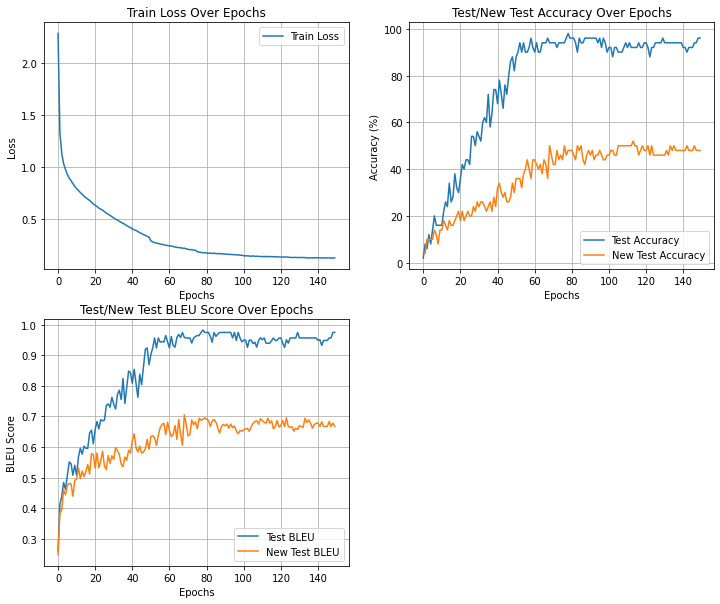

In [15]:
%matplotlib inline
plt.figure(figsize = (12, 10))

plt.subplot(2, 2, 1)
plt.plot(train_losses, label = 'Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss Over Epochs')
plt.legend()
plt.grid()

plt.subplot(2, 2, 2)
plt.plot([acc for acc in val_accs], label = 'Test Accuracy')
plt.plot([acc for acc in test_accs], label = 'New Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test/New Test Accuracy Over Epochs')
plt.legend()
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(val_bleus, label = 'Test BLEU')
plt.plot(test_bleus, label = 'New Test BLEU')
plt.xlabel('Epochs')
plt.ylabel('BLEU Score')
plt.title('Test/New Test BLEU Score Over Epochs')
plt.legend()
plt.grid()

plt.savefig('pic_all.png')
plt.show()

In [16]:
val_acc, val_loss, val_bleu = validation(valloader, model, device, logout = True)
print(f'Bleu-4 score:{val_bleu: .4f}, Accuracy:{val_acc / 100: .4f}')

input: contenpted
pred: contented
target: contented
input: begining
pred: beginning
target: beginning
input: problam
pred: problem
target: problem
input: dirven
pred: driven
target: driven
input: ecstacy
pred: ecstasy
target: ecstasy
input: juce
pred: juice
target: juice
input: localy
pred: locally
target: locally
input: compair
pred: compare
target: compare
input: pronounciation
pred: pronunciation
target: pronunciation
input: transportibility
pred: transportability
target: transportability
input: miniscule
pred: minuscule
target: minuscule
input: independant
pred: independent
target: independent
input: aranged
pred: arranged
target: arranged
input: poartry
pred: porty
target: poetry
input: leval
pred: level
target: level
input: basicaly
pred: basically
target: basically
input: triangulaur
pred: triangular
target: triangular
input: unexpcted
pred: unexpected
target: unexpected
input: stanerdizing
pred: standardizing
target: standardizing
input: varable
pred: variable
target: variable


In [17]:
test_acc, test_loss, test_bleu = validation(testloader, model, device, logout = True)
print(f'Bleu-4 score:{test_bleu: .4f}, Accuracy:{test_acc / 100: .4f}')

input: apreciate
pred: appreciate
target: appreciate
input: appeciate
pred: appreciate
target: appreciate
input: apprciate
pred: approximate
target: appreciate
input: apprecate
pred: apprecte
target: appreciate
input: apprecite
pred: apprecite
target: appreciate
input: luve
pred: love
target: love
input: culd
pred: culd
target: cold
input: heart
pred: heart
target: heart
input: televiseon
pred: television
target: television
input: thone
pred: phone
target: phone
input: phace
pred: pach
target: phase
input: poam
pred: ponim
target: poem
input: tomorraw
pred: tomorraw
target: tomorrow
input: presishan
pred: presition
target: precision
input: presishion
pred: precision
target: precision
input: presisian
pred: presisian
target: precision
input: presistion
pred: presition
target: precision
input: perver
pred: prever
target: prefer
input: predgudice
pred: progudice
target: prejudice
input: predgudis
pred: progheds
target: prejudice
input: recievor
pred: receiver
target: receiver
input: recio

In [14]:
model.load_state_dict(torch.load('latest-model.pth'))

<All keys matched successfully>

In [14]:
m = torch.load('all_store.pth')
epoch = m['epoch']
train_losses = m['train_losses']
val_losses = m['val_losses']
test_losses = m['test_losses']
val_bleus = m['val_bleus']
test_bleus = m['test_bleus']
val_accs = m['val_accs']
test_accs = m['test_accs']

In [30]:
# 平均準確率最高
avg = []
for i in range(len(val_accs)):
    avg.append(val_accs[i] + test_accs[i])
print(max(avg))
print(avg.index(max(avg)))
print(val_accs[78])
print(test_accs[78])

146.0
78
98.0
48.0


In [31]:
# val_accs最高時的test_accs多少
print(max(val_accs))
print(val_accs.index(max(val_accs)))
print(test_accs[78])

98.0
78
48.0


In [33]:
# test_accs最高時的val_accs多少
print(max(test_accs))
print(test_accs.index(max(test_accs)))
print(val_accs[113])

52.0
113
92.0


In [18]:
model.load_state_dict(torch.load('best-model-avg-acc.pth'))

<All keys matched successfully>

In [19]:
val_acc, val_loss, val_bleu = validation(valloader, model, device, logout = True)
print(f'Bleu-4 score:{val_bleu: .4f}, Accuracy:{val_acc / 100: .4f}')

input: contenpted
pred: contented
target: contented
input: begining
pred: beginning
target: beginning
input: problam
pred: problem
target: problem
input: dirven
pred: driven
target: driven
input: ecstacy
pred: ecstasy
target: ecstasy
input: juce
pred: juice
target: juice
input: localy
pred: locally
target: locally
input: compair
pred: compare
target: compare
input: pronounciation
pred: pronunciation
target: pronunciation
input: transportibility
pred: transportability
target: transportability
input: miniscule
pred: minuscule
target: minuscule
input: independant
pred: independent
target: independent
input: aranged
pred: arranged
target: arranged
input: poartry
pred: porty
target: poetry
input: leval
pred: level
target: level
input: basicaly
pred: basically
target: basically
input: triangulaur
pred: triangular
target: triangular
input: unexpcted
pred: unexpected
target: unexpected
input: stanerdizing
pred: standardizing
target: standardizing
input: varable
pred: variable
target: variable


In [20]:
test_acc, test_loss, test_bleu = validation(testloader, model, device, logout = True)
print(f'Bleu-4 score:{test_bleu: .4f}, Accuracy:{test_acc / 100: .4f}')

input: apreciate
pred: appreciate
target: appreciate
input: appeciate
pred: appreciate
target: appreciate
input: apprciate
pred: approximate
target: appreciate
input: apprecate
pred: apprecriate
target: appreciate
input: apprecite
pred: apprecite
target: appreciate
input: luve
pred: love
target: love
input: culd
pred: culd
target: cold
input: heart
pred: heart
target: heart
input: televiseon
pred: television
target: television
input: thone
pred: thone
target: phone
input: phace
pred: pack
target: phase
input: poam
pred: poem
target: poem
input: tomorraw
pred: tomorraw
target: tomorrow
input: presishan
pred: presitian
target: precision
input: presishion
pred: precision
target: precision
input: presisian
pred: precisian
target: precision
input: presistion
pred: presition
target: precision
input: perver
pred: prever
target: prefer
input: predgudice
pred: progudice
target: prejudice
input: predgudis
pred: prognadis
target: prejudice
input: recievor
pred: receiver
target: receiver
input: re